# Explicabilidad del Modelo (XAI) con SHAP

En este notebook analizamos el comportamiento del modelo de detección de fraude utilizando **SHAP (SHapley Additive exPlanations)**.

El objetivo es entender no solo **qué** predice el modelo, sino **por qué** lo predice, desglosando la decisión en:
1.  **Explicabilidad Global:** ¿Qué variables son las más importantes para el modelo en general?
2.  **Explicabilidad Local:** ¿Por qué se clasificó una transacción específica como fraude?

Este análisis es crucial para cumplir con normativas bancarias y generar confianza en el sistema automático.

In [16]:
# Celda 1: Configuración del entorno
import sys
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import joblib

# Ajuste de rutas:
# Si tu notebook está en la carpeta 'notebooks/', necesitamos subir un nivel
# para ver la carpeta 'src/'.
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Importamos tus módulos personalizados del TFG
from src.load_data import load_fraud_csv, load_credit_scoring_data
from src.train_model import train_model_with_cost

# Inicializamos JS para ver los gráficos interactivos de SHAP
shap.initjs()

print("Entorno configurado correctamente.")

Entorno configurado correctamente.


In [17]:
# Celda 2: Carga de datos
ruta_dataset = '../data/credit_card.csv'

if not os.path.exists(ruta_dataset):
    print(f"⚠️ Error: No se encuentra el archivo en {ruta_dataset}")
else:
    # Usamos tu función de src/load_data.py
    df, X, y = load_fraud_csv(ruta_dataset)
    print("Datos cargados.")

Loaded 284,807 transactions from credit_card.csv
Fraud rate: 0.17275%
Total fraud amount: $60,127.97
Datos cargados.


In [18]:
# Celda 3: Split de datos y preparación
# Dividimos en 80% train / 20% test, manteniendo la proporción de fraude (stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Extraemos la variable 'Amount' del train para el entrenamiento con coste sensible
amount_train = X_train['Amount']

print(f"Dimensiones de X_test: {X_test.shape}")

Dimensiones de X_test: (56962, 29)


In [19]:
# Celda 4: Entrenamiento del Modelo Ganador (XGBoost Factor 20)
print("Entrenando XGBoost con Coste (Factor=20)...")

# Llamamos a tu función de src/train_model.py
model = train_model_with_cost(X_train, y_train, amount_train, model_type="xgb", amount_factor=20)

print("¡Modelo entrenado y listo para explicar!")

Entrenando XGBoost con Coste (Factor=20)...
Model XGB trained (factor=20)
¡Modelo entrenado y listo para explicar!


In [20]:
# Celda 5: Cálculo de valores SHAP con Muestreo (Sampling)
print("Calculando valores SHAP... (esto puede tardar unos segundos)")

# TRUCO: Usamos una muestra de 1000 transacciones para evitar que se cuelgue.
# 1000 es suficiente para una explicabilidad global fiable.
X_test_sample = X_test.sample(50000, random_state=42)

# Inicializamos el explicador para árboles (optimizado para XGBoost)
explainer = shap.TreeExplainer(model)

# Calculamos los valores SHAP solo para la muestra
shap_values = explainer(X_test_sample)

print(f"Cálculo completado. Forma de los valores SHAP: {shap_values.shape}")

Calculando valores SHAP... (esto puede tardar unos segundos)
Cálculo completado. Forma de los valores SHAP: (50000, 29)


## 1. Interpretación Global del Modelo

El siguiente gráfico de **Beeswarm** resume cómo cada variable afecta al riesgo de fraude:
* **Eje Y:** Las variables ordenadas por importancia (la de arriba es la más influyente).
* **Eje X (SHAP Value):** Impacto en la predicción. Valores positivos (derecha) aumentan la probabilidad de fraude; negativos (izquierda) la disminuyen.
* **Color:** El valor de la variable original (Rojo = Alto, Azul = Bajo).

**Interpretación esperada:**
Observaremos que variables como `RevolvingUtilizationOfUnsecuredLines` o `Amount` suelen tener valores SHAP altos cuando su valor original es alto (puntos rojos a la derecha), indicando que un alto uso de líneas de crédito o montos grandes disparan la alarma de fraude.

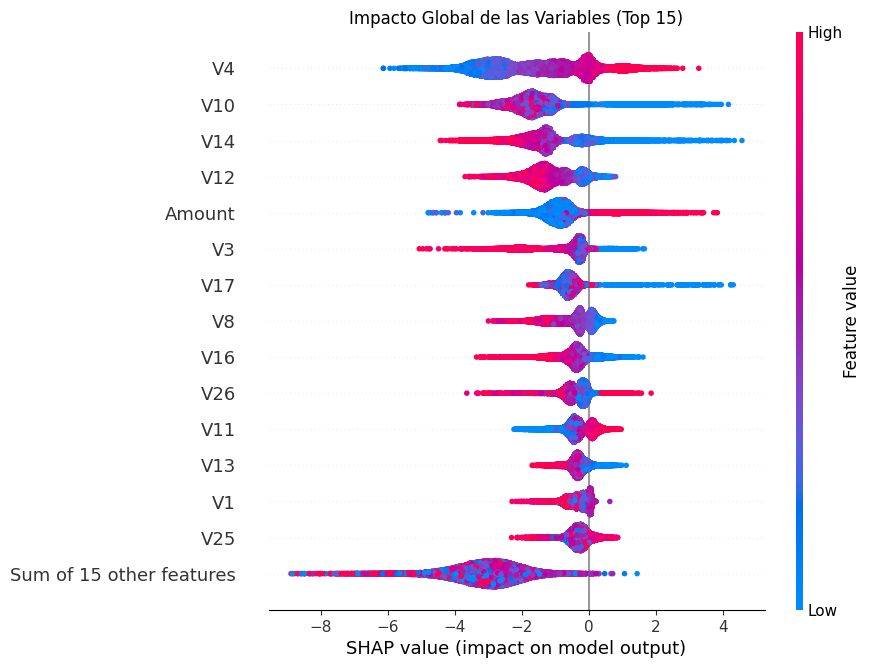

In [21]:
# Celda 6: Gráfico Global (Beeswarm)
plt.figure()
plt.title("Impacto Global de las Variables (Top 15)")

# El gráfico Beeswarm muestra la importancia y el sentido (positivo/negativo)
shap.plots.beeswarm(shap_values, max_display=15)

output_path = '../results/beeswarm_fraude_global.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

In [22]:
# Celda 7: Buscar un fraude real dentro de la muestra
# Filtramos los índices que son fraude (y=1) y que además están en nuestra muestra pequeña
indices_fraude_real = y_test[y_test == 1].index
indices_en_muestra = [i for i in indices_fraude_real if i in X_test_sample.index]
print(len(indices_en_muestra))

if len(indices_en_muestra) > 0:
    id_transaccion = indices_en_muestra[0] # Cogemos el primero que encontremos
    
    # Buscamos en qué posición (0 a 999) de la matriz SHAP está este ID
    posicion_shap = list(X_test_sample.index).index(id_transaccion)
    
    print(f"Vamos a analizar la transacción ID: {id_transaccion}")
    print(f"Monto de la transacción: {X_test.loc[id_transaccion, 'Amount']}€")
    print(f"Posición en el array SHAP: {posicion_shap}")
else:
    print("No se encontraron fraudes reales en la muestra aleatoria de 1000.")
    # Si pasa esto, aumenta el tamaño de la muestra en la Celda 5 a 2000 o 3000.

82
Vamos a analizar la transacción ID: 77348
Monto de la transacción: 0.01€
Posición en el array SHAP: 45341


## 2. Interpretación Local: Análisis de Casos Específicos

A continuación, utilizamos gráficos de **Waterfall (Cascada)** para deconstruir la predicción de transacciones individuales.

* $E[f(x)]$: Es el "valor base" o la probabilidad promedio de fraude del conjunto de datos.
* Cada barra muestra cómo una variable empuja la probabilidad hacia arriba (rojo/fraude) o hacia abajo (azul/legítimo) desde ese valor base.
* $f(x)$: Es la puntuación final otorgada por el modelo a esta transacción.

<Figure size 640x480 with 0 Axes>

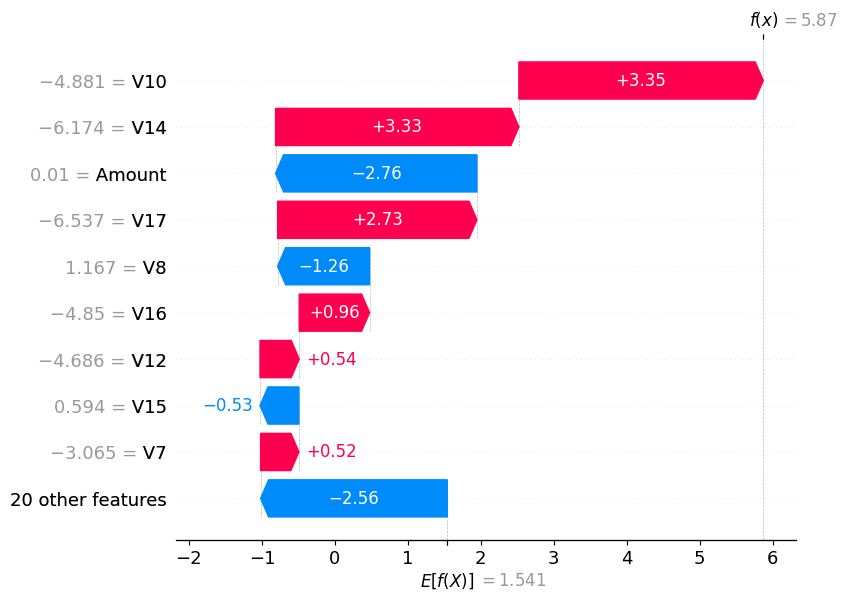

In [23]:
# Celda 8: Gráfico de Cascada (Waterfall) para el fraude seleccionado
if len(indices_en_muestra) > 0:
    plt.figure()

    output_path = '../results/waterfall_fraude.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    # Pasamos el objeto shap_values específico de esa fila
    shap.plots.waterfall(shap_values[posicion_shap])

### Caso A: Transacción de Alto Riesgo (Posible Fraude)

En este ejemplo, analizamos una transacción que el modelo ha marcado con una alta probabilidad de ser fraude.

**Análisis:**
Podemos ver las "culpables" principales. Por ejemplo, si `NumberOfTime30-59DaysPastDueNotWorse` aparece en rojo con un valor alto, significa que el historial de impagos recientes del cliente es la razón principal por la que el modelo desconfía de esta operación específica.


--- Buscando Falsos Negativos (Fraudes que se nos escaparon) ---
Analizando Falso Negativo ID: 157585
Importe perdido: 1.0€


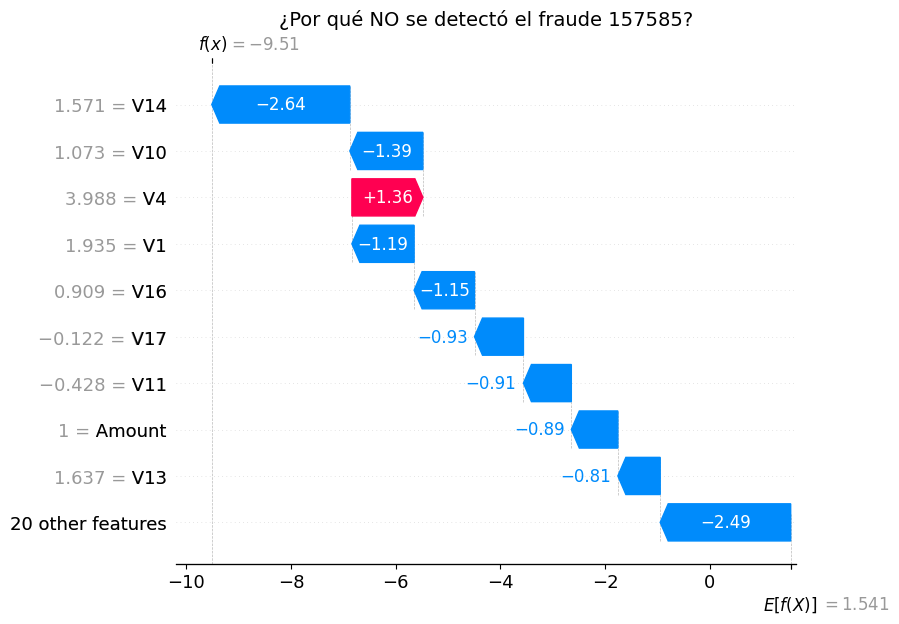

In [24]:
# Celda 10: Análisis de Errores - Explicar un Falso Negativo (Fraude no detectado)
print("\n--- Buscando Falsos Negativos (Fraudes que se nos escaparon) ---")

# 1. Hacemos predicciones sobre la muestra
preds_muestra = model.predict(X_test_sample)

# 2. Buscamos índices donde Realidad=1 (Fraude) pero Predicción=0 (Legítimo)
falsos_negativos = [i for i, y_real, y_pred in zip(X_test_sample.index, y_test.loc[X_test_sample.index], preds_muestra) 
                    if y_real == 1 and y_pred == 0]

if len(falsos_negativos) > 0:
    idx_fn = falsos_negativos[0] # Cogemos el primero
    pos_fn = list(X_test_sample.index).index(idx_fn)
    
    print(f"Analizando Falso Negativo ID: {idx_fn}")
    print(f"Importe perdido: {X_test_sample.loc[idx_fn, 'Amount']}€")
    
    # Waterfall plot para ver por qué el modelo bajó la puntuación
    plt.figure()
    shap.plots.waterfall(shap_values[pos_fn], show=False)
    plt.title(f"¿Por qué NO se detectó el fraude {idx_fn}?", fontsize=14)
    plt.show()
else:
    print("¡Increíble! El modelo no tuvo falsos negativos en esta muestra (o la muestra es muy pequeña).")

# ==========================================
# PARTE 2: EXPLICABILIDAD - CREDIT SCORING (SHAP)
# ==========================================

En esta sección utilizamos la técnica **SHAP (SHapley Additive exPlanations)** para abrir la "caja negra" de nuestro modelo de riesgo de crédito.
El objetivo es responder a dos preguntas clave para el negocio y el regulador:
1.  **Explicabilidad Global:** ¿Qué variables (Ingresos, Deuda, Edad...) tienen más peso general en la decisión de conceder un crédito?
2.  **Explicabilidad Local:** Ante un cliente concreto rechazado, ¿cuáles fueron las razones exactas? (Esencial para dar feedback al cliente).

In [10]:
# 1. Cargar Datos y Modelo
df_cs, X_cs, y_cs = load_credit_scoring_data('../data/cs-training.csv')
X_train, X_test, y_train, y_test = train_test_split(X_cs, y_cs, test_size=0.2, stratify=y_cs, random_state=42)

model_path = '../models/credit_scoring_final_model.pkl'
model = joblib.load(model_path)
print(f"Modelo cargado: {type(model).__name__}")

# 2. Configurar SHAP (API Moderna)
# Usamos check_additivity=False para evitar errores menores de precisión numérica en RF
explainer = shap.TreeExplainer(model)

Credit Scoring Data Loaded: 150,000 records
Default Rate: 6.68%
Total Estimated Exposure: $4,816,130,055
Modelo cargado: RandomForestClassifier


In [11]:
# 3. Calcular SHAP Values (Usando una muestra para no saturar la RAM)
# Seleccionamos 300 muestras para las gráficas globales
X_shap_sample = X_test.sample(3000, random_state=42)

print("Calculando explicaciones (esto tarda un poco con RF)...")
# LA CLAVE: Llamar al explainer como función devuelve un objeto 'Explanation' completo
shap_values_obj = explainer(X_shap_sample)

Calculando explicaciones (esto tarda un poco con RF)...


In [25]:
# CORRECCIÓN DE DIMENSIONES PARA RANDOM FOREST
# Random Forest devuelve dimensiones (n_samples, n_features, n_classes).
# Queremos solo la dimensión de la Clase 1 (Riesgo de Impago).
# Si el shape tiene 3 dimensiones, hacemos el slicing [:, :, 1]
if len(shap_values_obj.shape) == 3:
    print(f"Ajustando dimensiones SHAP: {shap_values_obj.shape} -> Seleccionando Clase 1")
    shap_values_target = shap_values_obj[:, :, 1]
else:
    shap_values_target = shap_values_obj

print("✅ Datos listos para graficar.")

Ajustando dimensiones SHAP: (3000, 11, 2) -> Seleccionando Clase 1
✅ Datos listos para graficar.



--- IMPACTO GLOBAL DE VARIABLES ---


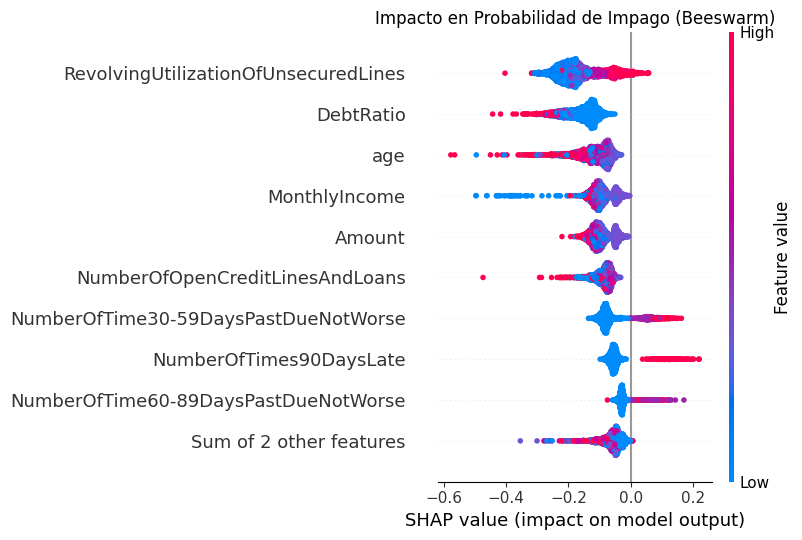

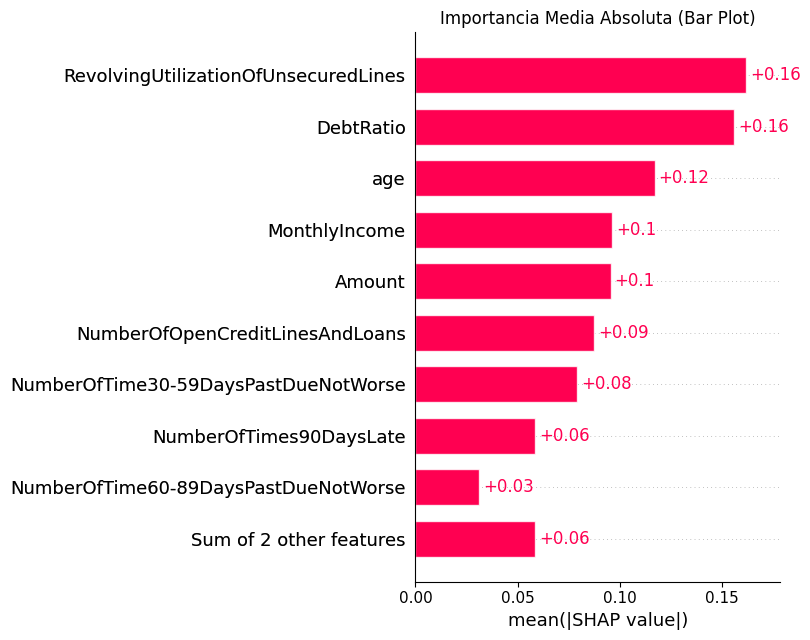

In [13]:
print("\n--- IMPACTO GLOBAL DE VARIABLES ---")

plt.figure(figsize=(10, 6))
plt.title("Impacto en Probabilidad de Impago (Beeswarm)")
# beeswarm maneja automáticamente el objeto Explanation
shap.plots.beeswarm(shap_values_target, show=False)
plt.tight_layout()

output_path = '../results/beeswarm_creditscoring_global.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

plt.figure(figsize=(10, 6))
plt.title("Importancia Media Absoluta (Bar Plot)")
shap.plots.bar(shap_values_target, show=False)
plt.tight_layout()
plt.show()


--- ANÁLISIS INDIVIDUAL (WATERFALL) ---
Explicando decisión para cliente (Índice muestra: 3)
Probabilidad Modelo: 56.50%
Umbral Corte:        28.00%


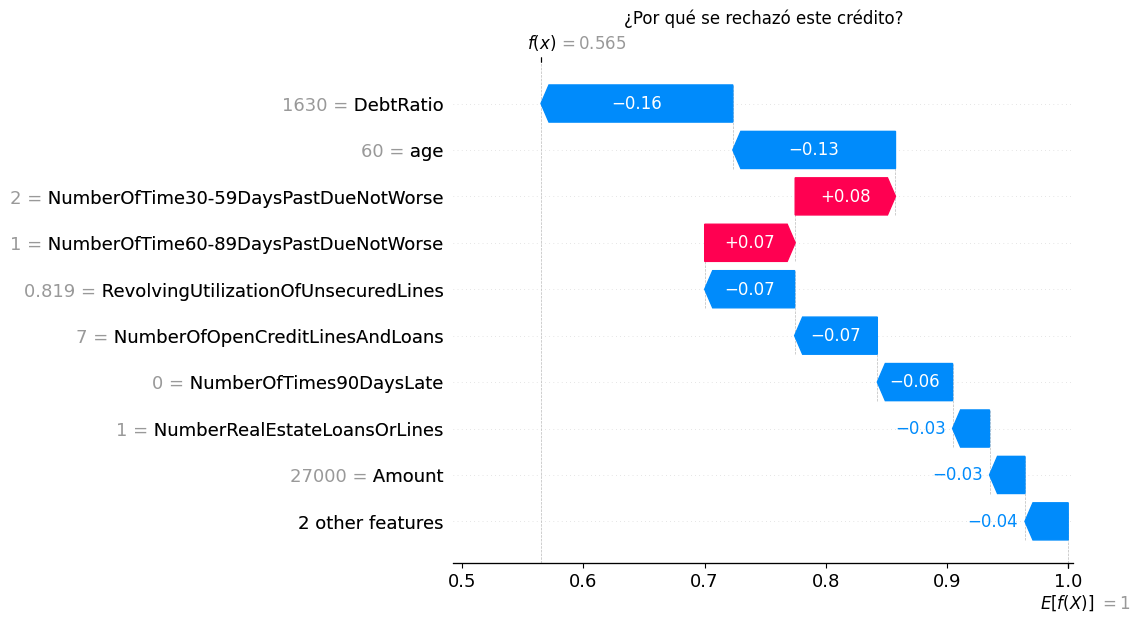

In [14]:
print("\n--- ANÁLISIS INDIVIDUAL (WATERFALL) ---")

# Definir Umbral Operativo (Calculado en análisis de sensibilidad)
OPERATING_THRESHOLD = 0.28 #

# Buscar un cliente rechazado en la muestra
probs_sample = model.predict_proba(X_shap_sample)[:, 1]
rejected_indices_local = np.where(probs_sample > OPERATING_THRESHOLD)[0]

if len(rejected_indices_local) > 0:
    # Elegir el primero de la muestra
    idx_in_sample = rejected_indices_local[0]
    
    # Extraer el objeto Explanation de ESE cliente
    # shap_values_target ya tiene los nombres de columnas y datos base integrados
    single_explanation = shap_values_target[idx_in_sample]
    
    print(f"Explicando decisión para cliente (Índice muestra: {idx_in_sample})")
    print(f"Probabilidad Modelo: {probs_sample[idx_in_sample]:.2%}")
    print(f"Umbral Corte:        {OPERATING_THRESHOLD:.2%}")
    
    plt.figure()
    # El gráfico waterfall ahora recibe directamente el objeto explanation individual
    shap.plots.waterfall(single_explanation, show=False, max_display=10)
    plt.title("¿Por qué se rechazó este crédito?")

    output_path = '../results/waterfall_creditscoring.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    plt.show()
    
else:
    print("No hay clientes rechazados en esta pequeña muestra para graficar.")


--- DEPENDENCIA: EDAD vs DEUDA ---


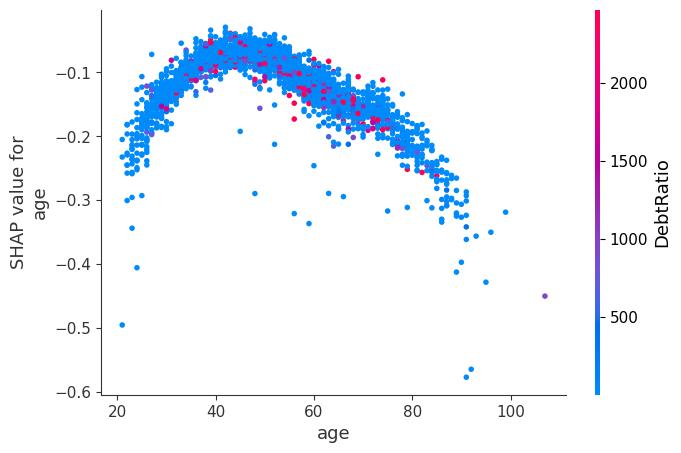

In [15]:
print("\n--- DEPENDENCIA: EDAD vs DEUDA ---")
# Para dependence plot, pasamos los valores numéricos (.values) y los datos (X_shap_sample)
shap.dependence_plot(
    "age", 
    shap_values_target.values, 
    X_shap_sample, 
    interaction_index="DebtRatio"
)